# Analysing Brooklyn's airbnb trends

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Importing and cleaning the data

[![png](images/nyc_airbnb.png)](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data)

We'll use an open source dataset from Kaggle that contains New York's Airbnb data for 2019.

In [2]:
airbnb = pd.read_csv('airbnb.csv', usecols = ['neighbourhood','neighbourhood_group', 'reviews_per_month',
                                              'availability_365','price', 'room_type', 'last_review'])

display(airbnb.head(10))

,neighbourhood_group,neighbourhood,room_type,price,last_review,reviews_per_month,availability_365
0,Brooklyn,Kensington,Private room,149,2018-10-19,0.21,365
1,Manhattan,Midtown,Entire home/apt,225,2019-05-21,0.38,355
2,Manhattan,Harlem,Private room,150,NaN,NaN,365
3,Brooklyn,Clinton Hill,Entire home/apt,89,2019-07-05,4.64,194
4,Manhattan,East Harlem,Entire home/apt,80,2018-11-19,0.10,0
5,Manhattan,Murray Hill,Entire home/apt,200,2019-06-22,0.59,129
6,Brooklyn,Bedford-Stuyvesant,Private room,60,2017-10-05,0.40,0
7,Manhattan,Hell's Kitchen,Private room,79,2019-06-24,3.47,220
8,Manhattan,Upper West Side,Private room,79,2017-07-21,0.99,0
9,Manhattan,Chinatown,Entire home/apt,150,2019-06-09,1.33,188


<br>Uppon a quick inspection of the dataset we can find several Nan values in different columns. NaNs tend to be a problem while handling datasets; let's see how widespread they are accross ours:

In [3]:
print(airbnb.isnull().sum())

neighbourhood_group        0
neighbourhood              0
room_type                  0
price                      0
last_review            10052
reviews_per_month      10052
availability_365           0
dtype: int64


<br>There are more than ten thousand NaN values in both the *last_review* column and the *reviews per moth* column. Let's find out how much that is compared to the total number of lines:

In [4]:
print('{:.2f} % NaN values'.format(airbnb.isnull().sum().reviews_per_month*100/len(airbnb)))

20.56 % NaN values


We have some ways of dealing with the NaN problem, just to name a few:
- Study where they are coming from; see if they are from a particular neighborhood or if they are split amongst all of them.
- Replace the NaN values with the mean value for that column for their neighborhood.
- Replace the NaN values with the global mean value for that column
- Discard the columns with the NaN values.
- Discard the rows with the NaN values.

Most of them would be time consuming, and dealing with NaNs is not the topic of this notebook. In this case, we'll just discard every row that has a NaN value:

In [5]:
airbnb.dropna(inplace=True)

<br>Another good practice is to look for duplicates:

In [6]:
print(airbnb.duplicated().sum())

9


We'll discard these rows:

In [7]:
airbnb.drop_duplicates(inplace = True)

<br>Now we'll lock for outliers in the data; values really out of place or just plainly wrong. This is easy to do through a boxplot:

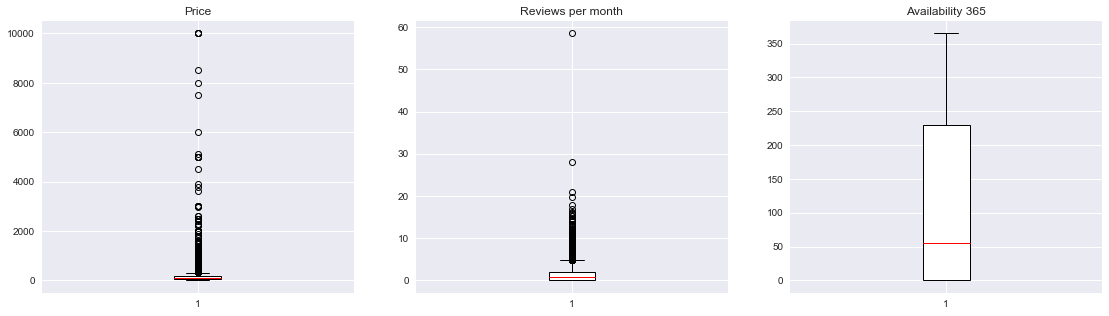

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))
columns = ['price', 'reviews_per_month', 'availability_365']
for column, ax in zip(columns, axs):
    box = ax.boxplot(airbnb[column], patch_artist=True)
    ax.set_title(column.replace('_', ' ').capitalize())
    # styling
    plt.setp(box['boxes'], color='white')
    plt.setp(box['boxes'], edgecolor='black')
    plt.setp(box['medians'], color='red')
plt.show()

The *availability* column looks fine; the *price* one, even with its high prices, seems reasonable too (there are some really expensive apartments in NY); but if we take a closer look at the *reviews per month* column we'll be able to see how one apartment has almost 60 reviews per month. And unless that apartment is close to a black hole that distorts time making one day there two days in real life, months have 31 days at max.

*Note: Last time I checked, Airbnb reservations are made by one person only and you have to book the place for the night, hence the consideration of that value as an outlier.*

We'll get rid of that outlier:

In [9]:
airbnb = airbnb[airbnb.reviews_per_month != airbnb['reviews_per_month'].max()]

<br>

### Williambsurg
Williamsburg is one of the trendiest neighborhoods nowadays. Since 2005 it has changed from an industrial district to a place that houses many young people and blooming businesses. We'll analyse how it does on Airbnb compared with the rest of the neighborhoods; for that, we'll take into account the *availability* and the *reviews per month*, which intuitively will let us know how solicited different neighborhoods are and how people rate them.

First, we'll categorise the listings by the ammount of reviews per month (rpm) they get. We'll split them into three categories:
- Low ammount of rpm.
- Medium ammount of rpm.
- High ammount of rpm.

In [10]:
# We create a new column to store the tag 
airbnb['reviews_tag'] = ''

# And divide the data using quantiles
quantiles = airbnb['reviews_per_month'].quantile([0.33, 0.66])

airbnb.loc[(airbnb.reviews_per_month > 0 ) & (airbnb.reviews_per_month <= quantiles.values[0]), 'reviews_tag'] = 'Low'
airbnb.loc[(airbnb.reviews_per_month > quantiles.values[0] ) & (airbnb.reviews_per_month <= quantiles.values[1]), 'reviews_tag'] = 'Medium'
airbnb.loc[(airbnb.reviews_per_month > quantiles.values[1] ), 'reviews_tag'] = 'High'

<br>Now we'll classify the listings based on their availability in a similar manner; we'll use the following tags:
- Low demand
- Average demand
- High demand

In [11]:
airbnb['availability_tag'] = ''

quantiles = airbnb['availability_365'].quantile([0.33, 0.66])

airbnb.loc[(airbnb.availability_365 <= quantiles.values[0]), 'availability_tag'] = 'Low demand'
airbnb.loc[(airbnb.availability_365 > quantiles.values[0] ) & (airbnb.availability_365 <= quantiles.values[1]), 'availability_tag'] = 'Average demand'
airbnb.loc[(airbnb.availability_365 > quantiles.values[1] ), 'availability_tag'] = 'High demand'

<br>Lastly, we'll relate the number of reviews with the availability to obtain a rating for the listing; if it's on high demand and it gets plenty of reviews, it's safe to assume its a very good place. On the oder hand, if it has low demand and has a high number of reviews per month, the place is probably not the best.

We'll use the following tags:
- Very good
- Good
- Average
- Bad
- Very bad

In [12]:
airbnb['classification'] = ''
classification_tags = ['Very good', 'Good', 'Average', 'Bad', 'Very bad']

airbnb.loc[(airbnb['reviews_tag'] == 'Low') & (airbnb['availability_tag'] == 'High demand'), 'classification'] = 'Good'
airbnb.loc[(airbnb['reviews_tag'] == 'Medium') & (airbnb['availability_tag'] == 'High demand'), 'classification'] = 'Good'
airbnb.loc[(airbnb['reviews_tag'] == 'High') & (airbnb['availability_tag'] == 'High demand'), 'classification'] = 'Very good'

airbnb.loc[(airbnb['reviews_tag'] == 'Low') & (airbnb['availability_tag'] == 'Average demand'), 'classification'] = 'Average'
airbnb.loc[(airbnb['reviews_tag'] == 'Medium') & (airbnb['availability_tag'] == 'Average demand'), 'classification'] = 'Average'
airbnb.loc[(airbnb['reviews_tag'] == 'High') & (airbnb['availability_tag'] == 'Average demand'), 'classification'] = 'Good'

airbnb.loc[(airbnb['reviews_tag'] == 'Low') & (airbnb['availability_tag'] == 'Low demand'), 'classification'] = 'Bad'
airbnb.loc[(airbnb['reviews_tag'] == 'Medium') & (airbnb['availability_tag'] == 'Low demand'), 'classification'] = 'Bad'
airbnb.loc[(airbnb['reviews_tag'] == 'High') & (airbnb['availability_tag'] == 'Low demand'), 'classification'] = 'Very bad'

<br>Let's see the changes:

In [13]:
display(airbnb.head())

,neighbourhood_group,neighbourhood,room_type,price,last_review,reviews_per_month,availability_365,reviews_tag,availability_tag,classification
0,Brooklyn,Kensington,Private room,149,2018-10-19,0.21,365,Low,High demand,Good
1,Manhattan,Midtown,Entire home/apt,225,2019-05-21,0.38,355,Medium,High demand,Good
3,Brooklyn,Clinton Hill,Entire home/apt,89,2019-07-05,4.64,194,High,High demand,Very good
4,Manhattan,East Harlem,Entire home/apt,80,2018-11-19,0.10,0,Low,Low demand,Bad
5,Manhattan,Murray Hill,Entire home/apt,200,2019-06-22,0.59,129,Medium,Average demand,Average


<br>Let's take a look at the top 10 neighborhoods in Brooklyn so we can see how Williamsburg compares:

In [14]:
brooklyn = airbnb.loc[airbnb.neighbourhood_group == 'Brooklyn', :]

top_10 = brooklyn['neighbourhood'].value_counts()[:10]

# Neighborhood names
top_10_names = top_10.index

# Their review count
top_10_nreviews = top_10.values

In [15]:
# This piece of code gets the number of reviews and puts them in a list for a later use in a graph
scores = []
for neighborhood in top_10_names:
    # For each neighborhood in the top 10, we get the ammount of classifications of each type
    reviews = airbnb.loc[airbnb.neighbourhood == neighborhood, 'classification'].value_counts().reindex(classification_tags).values
    scores.append(reviews)
scores = np.array(scores)

# Normalized scores 
scores_norm = scores * 100 / scores.sum(axis=1)[:, None]

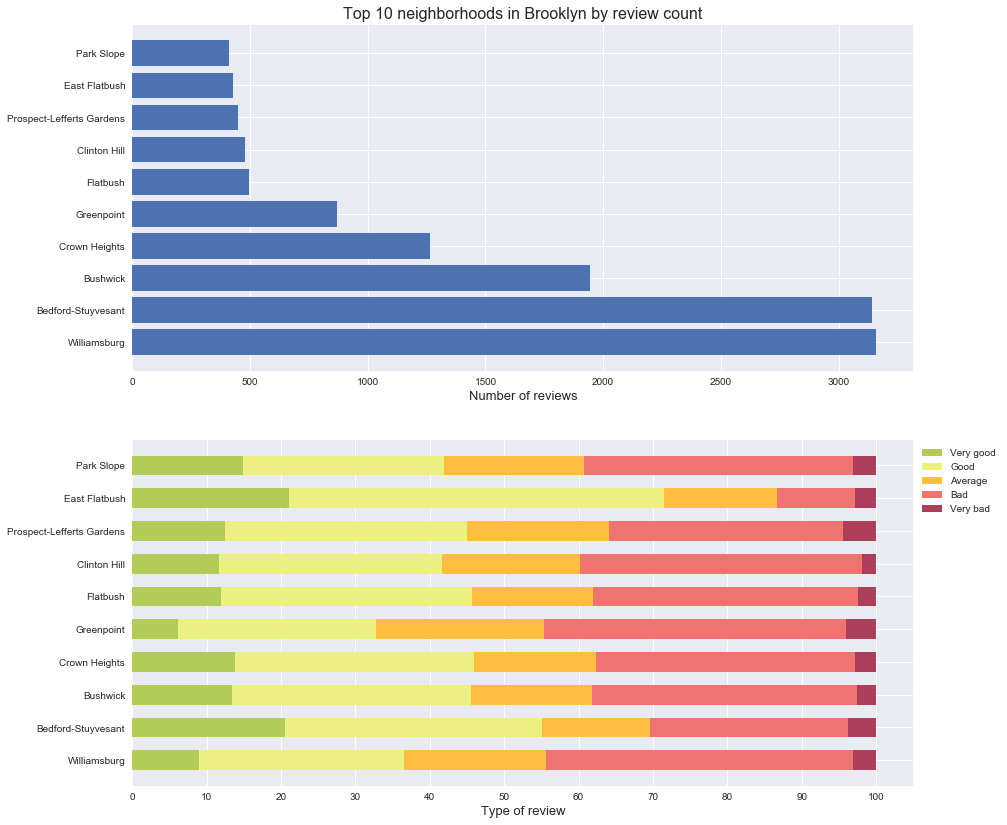

In [16]:
fig, ax = plt.subplots(2,1, figsize = (14,14))

# Number of reviews
ax[0].barh(top_10_names, top_10_nreviews)
ax[0].set_xlabel('Number of reviews', fontsize = 13)
ax[0].set_title('Top 10 neighborhoods in Brooklyn by review count', fontsize = 16)

# Type of reviews
scores_norm_cum = scores_norm.cumsum(axis=1)
colors = ['#B3CC57','#ECF081', '#FFBE40', '#EF746F', '#AB3E5B']
for i, (reviews, color) in enumerate(zip(scores, colors)):
    if i<5:
        widths = scores_norm[:,i]
        starts = scores_norm_cum[:,i] - widths
        ax[1].barh(top_10_names, widths, left = starts, height = 0.6, color = color)

ax[1].legend(classification_tags,
             loc = 'best', bbox_to_anchor = (1,1))
ax[1].set_xlabel('Type of review', fontsize = 13)
ax[1].set_xticks(np.arange(0,110,10))
plt.show()

En la primera de las anteriores gráficas que recogen el top 10 de barrios en Brooklyn, elegidos en función al número de reviews, se puede apreciar como Williamsburg es el que mayor número de reviews amasa, superando por poco al barrio de Bedford-Stuyvesant.
<br>Si bien ambos barrios están cerca en cuanto al número de reviews, en la segunda gráfica se muestran claramente diferenciados; el porcentaje de reviews no negativas de Williamsburg es casi un 20% superior al de Bedford, cuyas reviews negativas alcanzan casi un 40% del total.
<br>Hay dos casos de interés en la segunda gráfica; Williamsburg, por ser el barrio con mayor número de reviews y mayor proporción de reviews positivas frente al total, e East Flatbush, donde el número de reviews negativas superan al de positivas.

### 2. Los 5 barrios más populares

<br>Se agrupan los barrios por clasificación y se conservan aquellos 5 con más reviews del tipo "Muy bueno":

In [17]:
datos_barrios = airbnb.groupby('neighbourhood')['classification'].value_counts().unstack().fillna(0)
top_5 = datos_barrios.sort_values(by='Very good', ascending = False)[:5]
top_5 = top_5[classification_tags]

display(top_5)

classification,Very good,Good,Average,Bad,Very bad
neighbourhood,,,,,
Bedford-Stuyvesant,645.0,1084.0,455.0,840.0,117.0
Harlem,322.0,779.0,384.0,640.0,81.0
Hell's Kitchen,318.0,624.0,232.0,305.0,50.0
Williamsburg,283.0,873.0,599.0,1307.0,97.0
Bushwick,261.0,625.0,315.0,692.0,51.0


<br>Se obtienen los valores medios relevantes de cada barrio del top 5 (precio, número de reviews mensuales y disponibilidad):

In [27]:
top_5_data = airbnb.groupby(['neighbourhood', 'classification']).mean()
top_5_data = top_5_data.loc[list(top_5.index),:]
display(top_5_data)

price  reviews_per_month  \
neighbourhood      classification                                  
Bedford-Stuyvesant Average         109.784615           0.643934   
                   Bad              93.279762           0.279369   
                   Good            111.637454           1.927491   
                   Very bad         80.991453           2.749145   
                   Very good       114.758140           3.001256   
Bushwick           Average          89.600000           0.605397   
                   Bad              74.843931           0.279986   
                   Good             86.387200           2.076224   
                   Very bad         66.235294           2.561961   
                   Very good       107.593870           3.140843   
Harlem             Average         140.229167           0.636589   
                   Bad              97.601562           0.301047   
                   Good            119.948652           1.751720   
                   Very bad         93.888889           2.587654   
                   Very good       127.177019           2.934534   
Hell's Kitchen     Average         178.538793           0.709440   
                   Bad             165.147541           0.294689   
                   Good            194.878205           1.951058   
                   Very bad        185.940000           3.127000   
                   Very good       195.172956           3.737296   
Williamsburg       Average         152.343907           0.623573   
                   Bad             121.692425           0.265746   
                   Good            145.647194           1.884765   
                   Very bad        122.278351           2.419485   
                   Very good       185.812721           3.090883   

                                   availability_365  
neighbourhood      classification                    
Bedford-Stuyvesant Average                54.663736  
                   Bad                     0.019048  
                   Good                  175.155904  
                   Very bad                0.102564  
                   Very good             270.220155  
Bushwick           Average                53.847619  
                   Bad                     0.017341  
                   Good                  167.948800  
                   Very bad                0.058824  
                   Very good             267.160920  
Harlem             Average                60.968750  
                   Bad                     0.017188  
                   Good                  179.225931  
                   Very bad                0.148148  
                   Very good             255.701863  
Hell's Kitchen     Average                50.409483  
                   Bad                     0.022951  
                   Good                  193.104167  
                   Very bad                0.160000  
                   Very good             251.515723  
Williamsburg       Average                49.784641  
                   Bad                     0.017598  
                   Good                  164.484536  
                   Very bad                0.082474  
                   Very good             270.038869

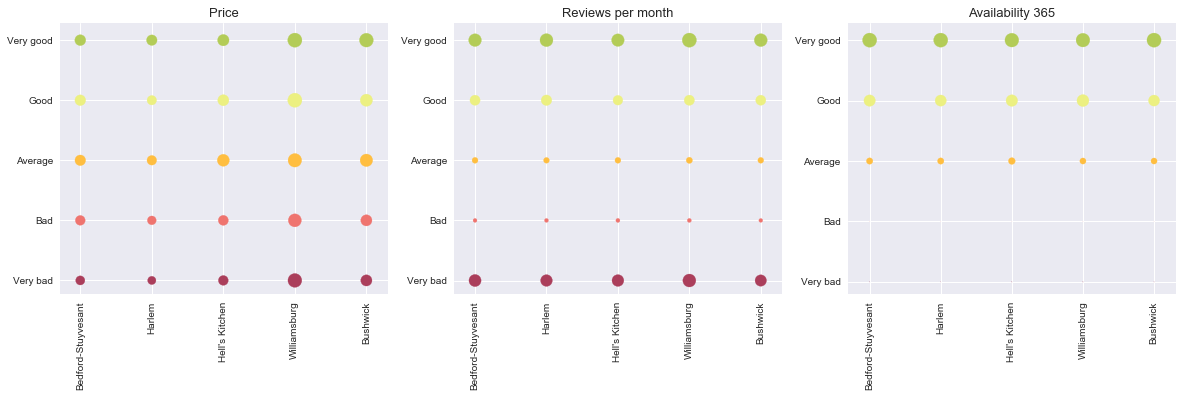

In [31]:
plot_reviews = list(top_5.columns)[::-1]

colors = ['#B3CC57','#ECF081', '#FFBE40', '#EF746F', '#AB3E5B']
plots = ['price', 'reviews_per_month', 'availability_365']
colors = colors[::-1]

fig, ax = plt.subplots(1,3, figsize=(20,5))
for i, plot in enumerate(plots):

    
    sizes = []
    for review in plot_reviews:
        sizes.append(top_5_data.xs(review, level='classification', drop_level = False)[plot].values)
    
    # up-scaling for a better view
    sizes = np.array(sizes)
    sizes = (200 * sizes) / sizes.max()
        
    for j, (size, color) in enumerate(zip(sizes, colors)):
        x = np.arange(0, len(size), 1)
        y = np.full(len(sizes), j)
        ax[i].scatter(x, y, size, c = color)

    ax[i].set_yticks(np.arange(5))
    ax[i].set_xticks(np.arange(5))
    ax[i].set_xticklabels(top_5.index, rotation = 'vertical')
    ax[i].set_yticklabels(plot_reviews)

    ax[i].set_title(plot.replace('_', ' ').capitalize(), fontsize = 13)
    
plt.show()

Las anteriores gráficas nos muestran, de izquierda a derecha, como se distribuyen el precio, las reviews mensuales y la disponibilidad en función del barrio y la clasificación del lugar, interpretándose el tamaño de la burbuja como mayor o menor precio, menos o más reviews y mayor o menor disponibilidad. El color está asociado al tipo de review, al igual que en la primera gráfica.

<br>Empezando por la gráfica de la izquierda, se puede deducir que el precio del alojamiento entre los alojamientos clasificados como muy buenos y los muy malos no es muy dispar y sin embargo, se aprecia como el precio del alojamiento desciende ligeramente según mejora su clasificación; es probable que aquellos alojamientos clasificados como muy malos o malos fueran caros y no cumplieran las espectativas asociadas a un precio elevado, motivando a los usuarios a dejar una mala review. Por otro lado, aquellos con mejor clasificación tienen precios más reducidos, lo cual indica que probablemente cumplieran las espectativas que los usuarios tenían para precios más ajusados.

<br>En la gráfica del medio se puede apreciar una cierta simetría; parece que los usuarios son más propensos a dejar reviews cuando el alojamiento ha causado una fuerte impresión en ellos, bien por ser un muy buen alojamiento o un alojamiento terrible. Los usuarios tienden a recomendar aquellos alojamientos en los que han disfrutado y a prevenir a otros usuarios sobre alojamientos en los que han tenido una mala experiencia.

<br>La gráfica de la derecha muestra un gradiente pronunciado y de fácil interpretación; la calidad del alojamiento y su disponibilidad va de la mano, siendo la disponibilidad de los mejores casi inapreciable frente a la perfectamente visible disponibilidad de los peores alojamientos.

### 3. Diferencia entre alquilar un piso y una habitación

<i>Una vez obtenida la información del apartado anterior, queremos tratar de entender las
diferencias de precio entre alquilar un apartamento entero y una habitación privada. Usa los diagramas de
cajas donde cada uno de los 5 barrios más populares está representado por una caja y haz una interpretación
de los resultados</i>

In [20]:
top_5_data = airbnb.groupby(['neighbourhood', 'room_type']).mean()
top_5_data = top_5_data.loc[list(top_5.index),:]
display(top_5_data)

price  reviews_per_month  \
neighbourhood      room_type                                        
Bedford-Stuyvesant Entire home/apt  152.197497           1.702392   
                   Private room      68.107230           1.429504   
                   Shared room       39.521127           1.317324   
Bushwick           Entire home/apt  141.509632           1.606637   
                   Private room      62.425580           1.248227   
                   Shared room       33.416667           1.284444   
Harlem             Entire home/apt  173.345848           1.275165   
                   Private room      80.041796           1.379265   
                   Shared room       72.114286           1.524286   
Hell's Kitchen     Entire home/apt  233.328442           1.619255   
                   Private room     127.205357           2.055911   
                   Shared room       81.843373           2.780361   
Williamsburg       Entire home/apt  197.137667           1.087393   
                   Private room      83.486297           1.114857   
                   Shared room       76.333333           0.968095   

                                    availability_365  
neighbourhood      room_type                          
Bedford-Stuyvesant Entire home/apt        123.949235  
                   Private room           120.630515  
                   Shared room            196.521127  
Bushwick           Entire home/apt        104.278459  
                   Private room            93.878085  
                   Shared room            183.777778  
Harlem             Entire home/apt        100.529010  
                   Private room           117.886223  
                   Shared room            134.685714  
Hell's Kitchen     Entire home/apt        133.519187  
                   Private room           135.805357  
                   Shared room            214.939759  
Williamsburg       Entire home/apt         85.502868  
                   Private room            72.094965  
                   Shared room            123.666667